In [1]:
# from drive
!unzip ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip

Archive:  ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip
   creating: dataset/tfrecords/
   creating: dataset/tfrecords/valid/
  inflating: dataset/tfrecords/valid/file_valid_02-1551.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_01-2048.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_00-2048.tfrec  
   creating: dataset/tfrecords/train/
  inflating: dataset/tfrecords/train/file_train_21-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_00-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_47-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_50-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_25-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_20-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_62-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_52-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_36-2048.tfrec  
  inflating: dataset/tfrecords/train/file_trai

* Import modules

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/single-person-pose-estimation')

In [3]:
from configs import default_config as cfg
from model.hourglass import create_hourglass_model
from dataset_builder import DatasetBuilder

* Model

In [4]:
model = create_hourglass_model(cfg.NUM_KEYPOINTS, 
                                 cfg.HG_NUM_STACKS,
                                 cfg.HG_NUM_CHANNELS,
                                 cfg.IMAGE_SHAPE,
                                 cfg.HM_ACTIVATION)

Created Hourglass model:
    1. 2 stacks.
    2. 7034530 parameters. Call model.get_summary() for more detail.
    


In [ ]:
def compile_model_from_checkpoint(model, ckpt_path, optimizer, loss):
  ''' This function to load model only so optimizer and loss dont really matter
  Be cautious if use this model for training
  :param model:
  :param ckpt_path: should be anything before and '.ckpt'
  :param optimizer: 
  :param loss: applied for all outputs
  :Not support metrics yet
  :return a compiled tensorflow model
  '''
  model.load_weights(ckpt_path)
  model.compile(optimizer = optimizer, loss = loss)
  return model

In [ ]:
model = compile_model_from_checkpoint(model, '/content/drive/MyDrive/single-person-pose-estimation/temp/checkpoints/best_val_loss_weights.ckpt',
                                 optimizer = tf.keras.optimizers.Adam(),
                                 loss = tf.keras.losses.MeanSquaredError())

* Dataset

In [5]:
ds_builder = DatasetBuilder(cfg)

Train dataset with 66 tfrecords and 134214 examples.
Valid dataset with 3 tfrecords and 5647 examples.


In [6]:
ds_train, ds_valid =  ds_builder.build_datasets()

In [ ]:
ds = ds_builder.get_ds_prediction()

In [ ]:
it = iter(ds)

In [ ]:
imgs_batch, meta = next(it)

In [ ]:
imgs_batch[0]

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.6431373 , 0.6431373 , 0.44705886],
        [0.6550858 , 0.65906864, 0.46498165],
        [0.6687807 , 0.6766238 , 0.49080884],
        ...,
        [0.6359988 , 0.5411765 , 0.25591302],
        [0.63529414, 0.5450368 , 0.2509804 ],
        [0.63529414, 0.54901963, 0.2509804 ]],

       [[0.6431373 , 0.6431373 , 0.44705886],
        [0.6560971 , 0.66007996, 0.46801546],
        [0.67041427, 0.6782574 , 0.49570963],
        ...,
        [0.63456744, 0.53305525, 0.2570332 ],
        [0.6372544 , 0.54004264, 0.25300294],
        [0.639277  , 0.5450368 , 0.2509804 ]],

       [[0.6431373 , 0.64243263, 0.4477635 ],
        [0.65707725, 0.66071326, 0.47130272],
        [0.67212415, 0.6799673 , 0.5005862 ],
        ...,
        [0.6321672 , 0.517829  , 0.25569662],
        [0.64054173, 0.5305944 , 0.25632852],
        [0.6459559 , 0.53835785, 0.25520834]],

       ...,

       [[0.19678311, 0.11443015, 0.10266545],
        [0.20

In [ ]:
meta['ann_id']

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([ 230831,  442619,  559508,  560228,  439117,  514577,  538081,
       1234574, 1245349, 1259139, 1269164, 1303041, 1304800, 1306228,
       1311471, 1316935])>

* Predict whole dataset

In [ ]:
def heatmaps_to_keypoints_v1(heatmaps):
  ''' Work for one batch
  :param heatmaps: shape(64, 64, number of keypoints)
  :return np.array
  '''
  flattened_heatmaps = tf.reshape(heatmaps, (64*64, 17)).numpy()
  keypoints = np.zeros(shape=(17, 3), dtype=np.float32)
  for i in range(17):
    heatmap = flattened_heatmaps[:, i]
    index = np.argmax(heatmap)
    x = index%64
    y = index//64
    conf = heatmap[y*64 + x]
    keypoints[i, 0] = x
    keypoints[i, 1] = y
    keypoints[i, 2] = conf
  return keypoints

In [ ]:
def create_oks_obj(ann_id, image_id, pred_kpts, score):
  oks_obj = {}
  oks_obj['image_id'] = image_id
  oks_obj['ann_id'] = ann_id
  oks_obj['category_id'] = 1
  oks_obj['keypoints'] = pred_kpts
  oks_obj['score'] = score
  return oks_obj

In [ ]:
def gen_predictions_list(model, ds, ds_length, batch_size):
  num_iterations = int(np.ceil(ds_length/batch_size))
  it = iter(ds)
  list_of_prediction = []
  image_ids = []
  for i in range(num_iterations):
    images_batch, meta = next(it)
    pred = model.predict(images_batch)
    # need index j since meta is a dict that each item contains (batch_size) tensors
    for j, p in enumerate(pred[-1]): # only last output of the model
      # Each p is an example/instance

      # Get keypoints and undo them into original shape
      keypoints = heatmaps_to_keypoints_v1(p)
      original_width = int(meta['original_width'][j])
      original_height = int(meta['original_height'][j])
      bbox_x = float(meta['bbox_x'][j])
      bbox_y = float(meta['bbox_y'][j])
      offset_width = float(meta['offset_width'][j])
      offset_height = float(meta['offset_height'][j])
      x_coords = keypoints[:, 0] * (original_width/64) + (bbox_x - offset_width)
      y_coords = keypoints[:, 1] * (original_height/64) + (bbox_y - offset_height)
      confs = []
      coco_kpts = []
      for x, y, c in zip(x_coords, y_coords, keypoints[:, 2]):
        if c > 1e-2:
          coco_kpts.append(int(x))
          coco_kpts.append(int(y))
          coco_kpts.append(1) # visible flag should be 1
          confs.append(c)
        else:
          coco_kpts.append(0)
          coco_kpts.append(0)
          coco_kpts.append(1) # visible flag should be 1
          confs.append(0)
      # Get score
      score = float(np.mean(confs)) # need to convert to python float

      # Get other meta data for oks objt
      ann_id = int(meta['ann_id'][j])
      image_id = int(meta['image_id'][j])
      
      # oks object
      oks = create_oks_obj(ann_id, image_id, coco_kpts, score)
      list_of_prediction.append(oks)

      image_ids.append(image_id)
      
  return list_of_prediction, image_ids

In [ ]:
list_of_prediction, image_ids = gen_predictions_list(model, ds, ds_builder.num_valid_examples, 16)

In [ ]:
print(len(list_of_prediction))
print(ds_builder.num_valid_examples)

5647
5647


In [ ]:
list_of_prediction[0]

{'ann_id': 230831,
 'category_id': 1,
 'image_id': 139,
 'keypoints': [428,
  169,
  1,
  428,
  167,
  1,
  431,
  167,
  1,
  431,
  167,
  1,
  431,
  167,
  1,
  439,
  177,
  1,
  441,
  177,
  1,
  436,
  196,
  1,
  436,
  196,
  1,
  417,
  212,
  1,
  417,
  212,
  1,
  447,
  226,
  1,
  449,
  223,
  1,
  447,
  255,
  1,
  449,
  255,
  1,
  455,
  288,
  1,
  455,
  288,
  1],
 'score': 0.3166048526763916}

In [ ]:
from urllib.request import urlopen
import json

In [ ]:
with open("result_v1.json", "w") as outfile:
    json.dump(list_of_prediction, outfile)

In [ ]:
kpts = list_of_prediction[0]['keypoints']
x = [kpts[i] for i in range(len(kpts)) if i%3 == 0]
y = [kpts[i] for i in range(len(kpts)) if i%3 == 1]

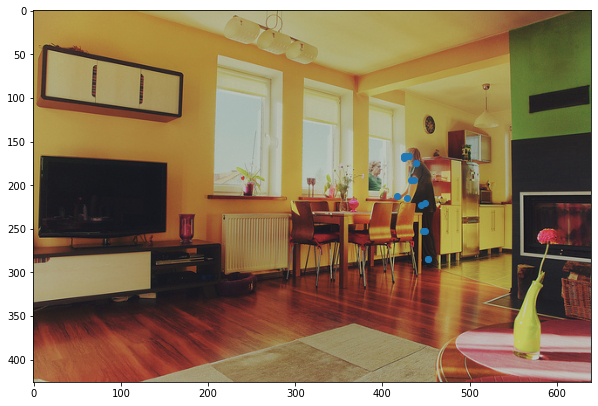

In [ ]:
f = urlopen("http://images.cocodataset.org/val2017/000000000139.jpg")
a = plt.imread(f, format = 'jpeg')
plt.figure(figsize =(10,10))
plt.imshow(a)
plt.scatter(x , y , marker = "o") # for heatmap size
plt.show()

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [ ]:
cocoGt= COCO('/content/drive/MyDrive/single-person-pose-estimation/dataset/annotations/person_keypoints_val2017.json')

loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


In [ ]:
cocoDt = cocoGt.loadRes('result_v1.json')

Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!


In [ ]:
annType = "keypoints"
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds = image_ids
cocoEval.params.catIds = [1] # Person category
cocoEval.evaluate()
cocoEval.accumulate()
print('\nSummary: ')
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=2.67s).
Accumulating evaluation results...
DONE (t=0.07s).

Summary: 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.543
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.203
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.643
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.396


0.291; 0.594; 0.264; 0.274; 0.325; 0.367; 0.676; 0.356; 0.676; 0.356; 0.323; 0.429

In [ ]:
stats = cocoEval.stats
stats

array([0.29090869, 0.59363386, 0.26331839, 0.27657598, 0.32030666,
       0.3657277 , 0.67443743, 0.35551238, 0.32196133, 0.42886195])



---


Demo

In [ ]:
image = tf.io.decode_image(tf.io.read_file("3.jpg"), channels=3, dtype=tf.dtypes.float32)
image = tf.image.resize(image, (256, 256))
image = tf.expand_dims(image, axis = 0)
image.shape

TensorShape([1, 256, 256, 3])

In [ ]:
pred = model.predict(image)

In [ ]:
pred[-1].shape

(1, 64, 64, 17)

In [ ]:
keypoints = heatmaps_to_keypoints_v1(pred[-1][0])
tf.print(keypoints)

array([[3.5000000e+01, 2.2000000e+01, 8.8174975e-01],
       [3.7000000e+01, 2.0000000e+01, 7.7926332e-01],
       [3.4000000e+01, 2.0000000e+01, 7.8356981e-01],
       [3.9000000e+01, 2.1000000e+01, 7.7217996e-01],
       [3.2000000e+01, 2.0000000e+01, 6.6739190e-01],
       [4.4000000e+01, 2.8000000e+01, 5.7165444e-01],
       [2.6000000e+01, 2.8000000e+01, 4.7898120e-01],
       [5.3000000e+01, 1.8000000e+01, 6.0361117e-01],
       [1.4000000e+01, 2.3000000e+01, 5.9590656e-01],
       [5.8000000e+01, 6.0000000e+00, 4.8728880e-01],
       [5.0000000e+00, 1.1000000e+01, 4.6923333e-01],
       [4.1000000e+01, 5.9000000e+01, 3.4541821e-01],
       [2.9000000e+01, 5.9000000e+01, 3.7454396e-01],
       [2.5000000e+01, 6.3000000e+01, 3.0960441e-03],
       [1.3000000e+01, 2.4000000e+01, 5.4749846e-03],
       [5.7000000e+01, 2.0000000e+00, 4.7374368e-03],
       [4.0000000e+00, 1.1000000e+01, 5.6198239e-03]], dtype=float32)


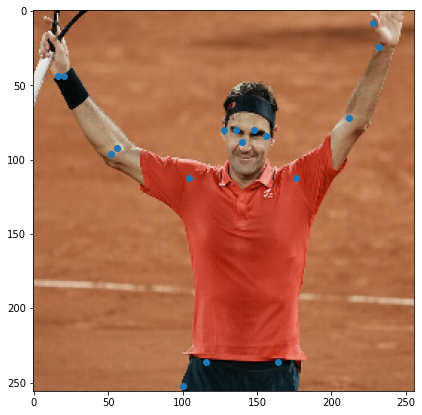

In [ ]:
plt.figure(figsize = (7,7))
plt.imshow(image[0])
plt.scatter(keypoints[:,0] *(256/64), keypoints[:, 1] * (256/64))